In [105]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from seaborn import pairplot
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as sm
from sklearn.linear_model import LinearRegression
import itertools
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\forre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
#This is a function that is used to assighn labels to the NLP used for the the 'Name'column which gives a short description about the listing
def pricecats(df,n):
    df=df.sort_values('price')
    repnum=len(df)/n
    addnum=len(df)-(math.floor(repnum)*n)
    pricecats=[]
    for i in range(1,n+1):
        pricecats=pricecats+[i]*int(repnum)
    pricecats=pricecats+[i]*int(addnum)
    df['pricecats']=pricecats
    return(df)

In [107]:
#function that creates document term matrix for NLP
def documentTermMatrix(df):
    vector = CountVectorizer()
    vector.fit(df['name'])
    training_data = vector.transform(df['name'])
    return(X_train_counts)

In [108]:
#function that does preprocessing of 'Name' column for NLP
def preprocessNLP(df):
    #preprocessing
    textdf=df['name']

    #lowercase
    textdf=textdf.str.lower()

    #punctuation
    textdf = textdf.str.replace('[^\w\s]','')

    #tokenization
    textdf=textdf.str.split()

    #stop words
    stop = stopwords.words('english')
    textdf=textdf.apply(lambda x: [item for item in x if item not in stop])
    textdf=textdf.apply(lambda x: ' '.join(x))
    
    df['name']=textdf
    return(df)

In [109]:
#function that assighns labels to test set based off of MultinomialNB classifier
def predictNLP(train,test):
    #Documeent term matrix
    vector = CountVectorizer()
    vector.fit(train['name'])
    traindtm = vector.transform(train['name'])
    
    #classifier
    sgd=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(traindtm, train['pricecats'])
    mnb = MultinomialNB().fit(traindtm, train['pricecats'])
    log=LogisticRegression(n_jobs=1, C=1e5)
    for model in [sgd,mnb,log]:
        model=model.fit(traindtm, train['pricecats'])
        vector = CountVectorizer(vocabulary=vector.vocabulary_)
        text_vector = vector.transform(test['name'])
        test['predictions']=model.predict(text_vector)
        print(str(model)+"= "+str(len(test[test['predictions']==test['pricecats']])/len(test)))
    model=mnb.fit(traindtm, train['pricecats'])
    vector = CountVectorizer(vocabulary=vector.vocabulary_)
    text_vector = vector.transform(test['name'])
    test['name']=model.predict(text_vector)
    test=test.drop(['predictions'], axis=1)   
    return(test)

In [110]:
#function that evaluates results of model wants the best feature set is found
def eveluateresults(features,train,test):
    trainX=train[features]
    trainY=train['price']
    testX=test[features]
    testY=test['price']
    if any(item in features for item in ['neighbourhood_group','room_type','name']):
        common=list(set(features).intersection(['neighbourhood_group','room_type','name']))
        column_trans = make_column_transformer((OneHotEncoder(), common),remainder='passthrough')
        trainX=column_trans.fit_transform(trainX)
        testX=column_trans.fit_transform(testX)
    model=LinearRegression()
    model.fit(trainX,trainY)
    y_test_pred=model.predict(testX)
        
        
    print(features)
    print("Mean absolute error =", round(sm.mean_absolute_error(testY, y_test_pred), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(testY, y_test_pred), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(testY, y_test_pred), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(testY, y_test_pred), 2)) 
    print("R2 score =", round(sm.r2_score(testY, y_test_pred), 2))

In [111]:
#find relative path and read in csv
for root, dirs, files in os.walk(os.path.dirname(os.path.abspath('AB_NYC_2019.csv'))):
    for name in files:
        if name == 'AB_NYC_2019.csv':
            path=os.path.abspath(os.path.join(root, name))

df=pd.read_csv(path)

In [112]:
#drop nan
df=df.dropna()

#find and drop outliers using sklearn isolation forest
np.random.seed(1)
clf = IsolationForest( behaviour = 'new', max_samples='auto', random_state = 1, contamination= 'auto')
preds = clf.fit_predict(df[['longitude','latitude','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']])
df['outliers']=preds
df.drop(df[df['outliers']==-1].index, inplace = True)
df=df.drop(['outliers'], axis=1)

c:\users\forre\appdata\local\programs\python\python38\lib\site-packages\sklearn\ensemble\_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


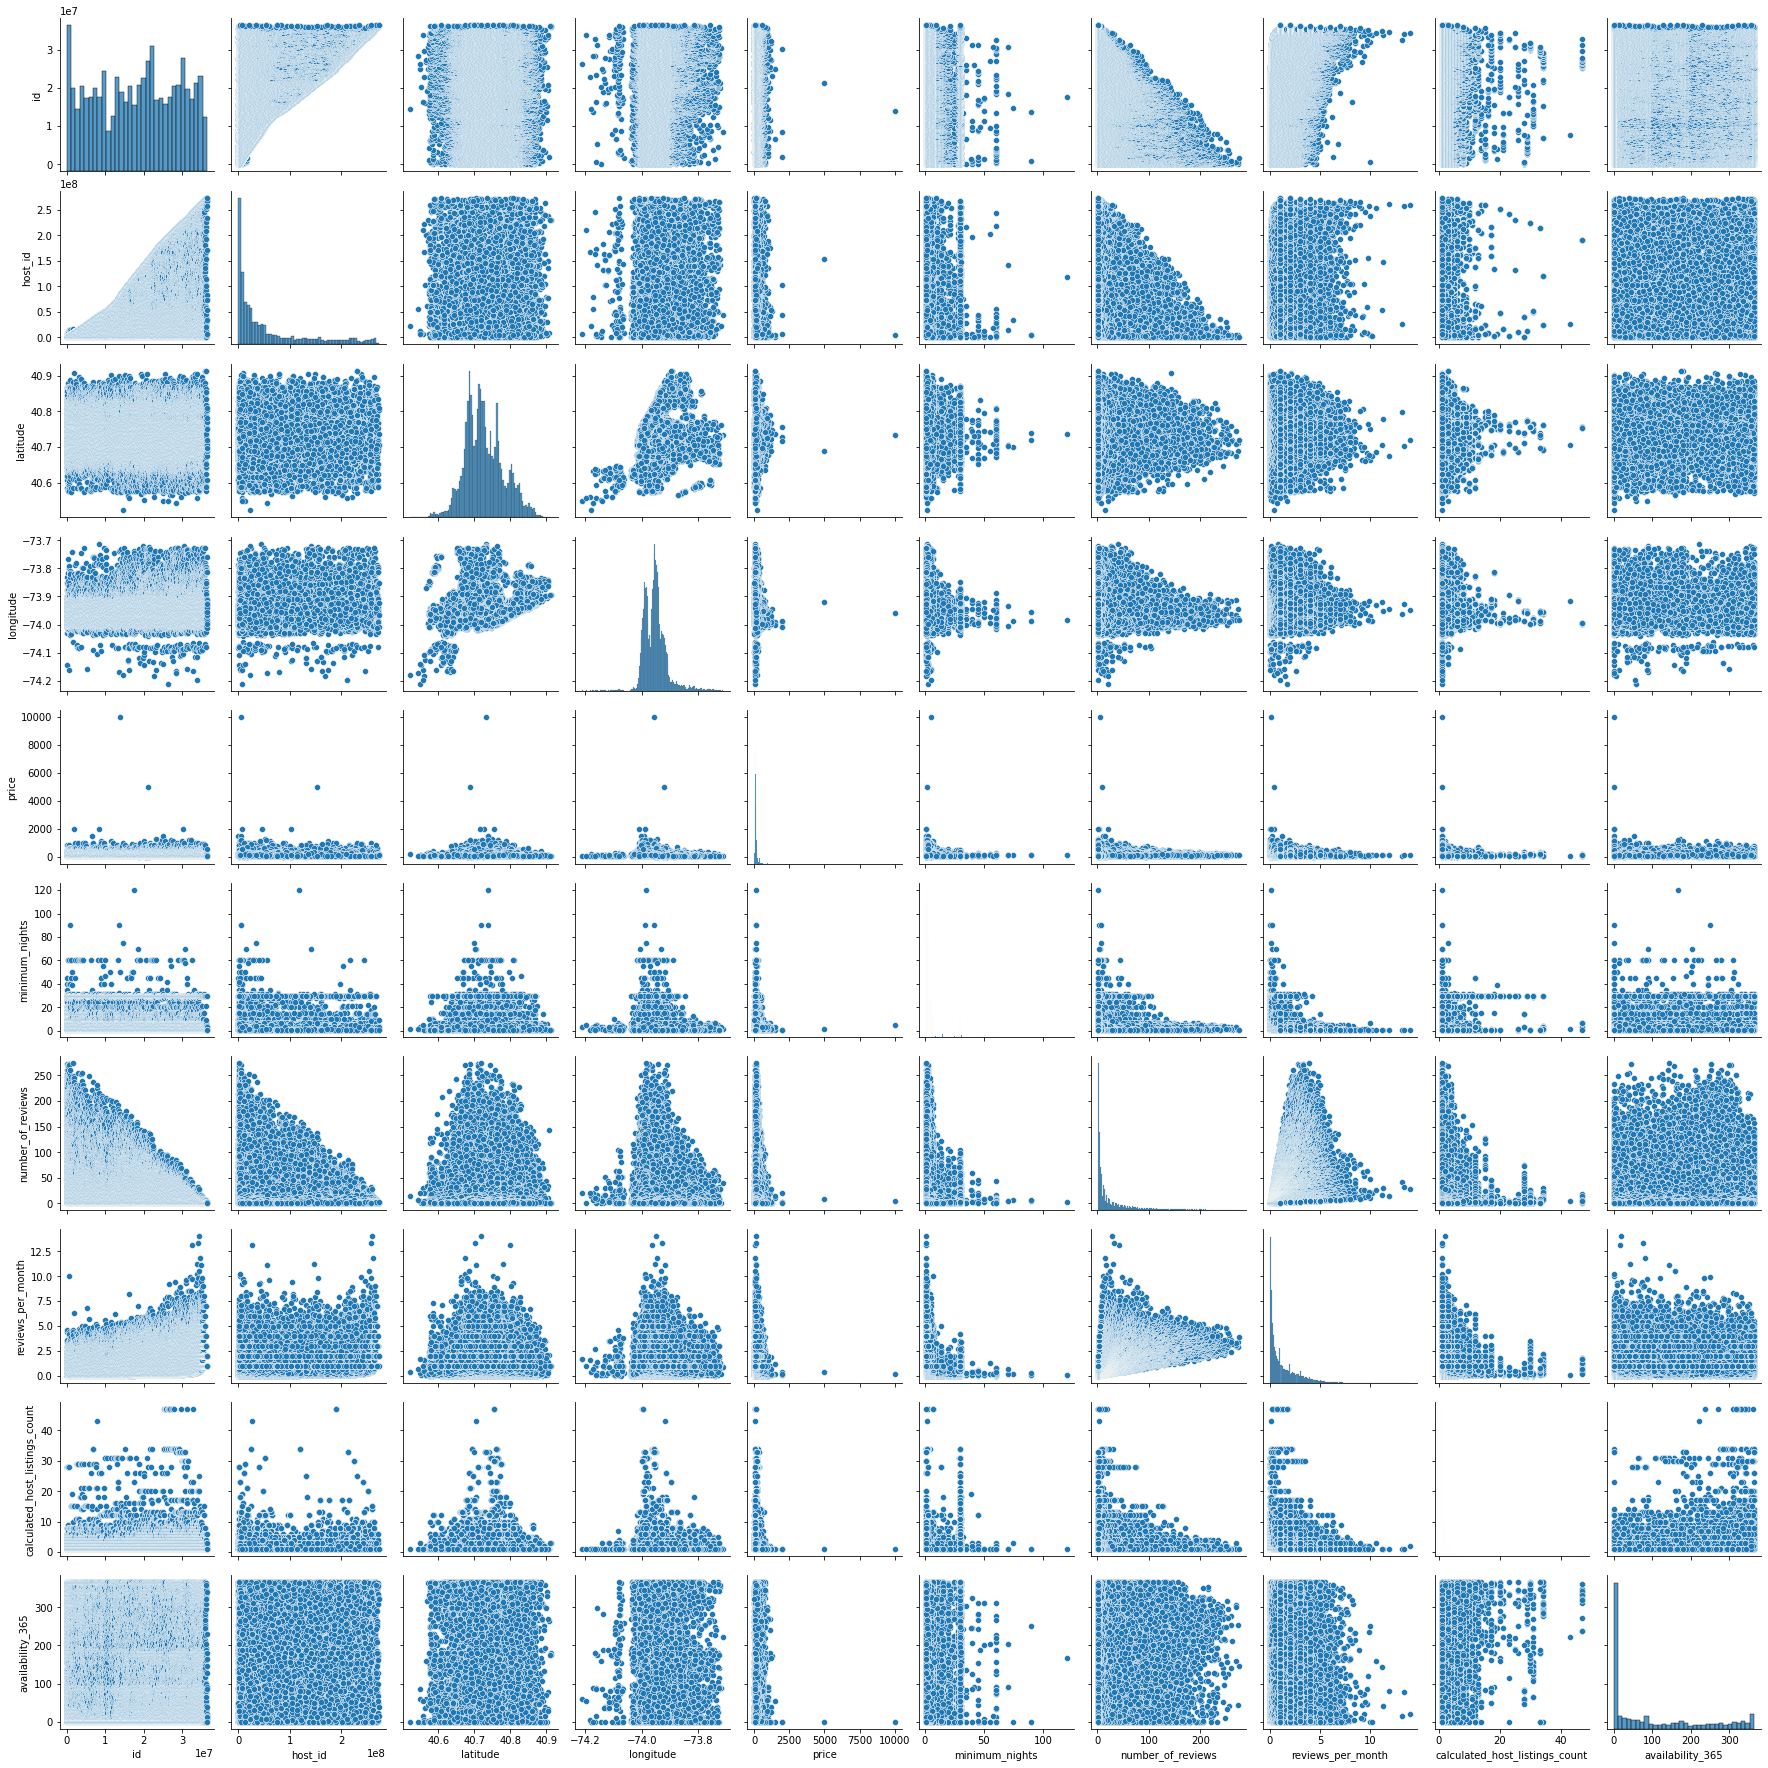

In [179]:
#analyze variables using seaborn.pairplot
pairplot(df)

In [113]:
#Preprocess 'Name' column
df=preprocessNLP(df)

In [114]:
#create train and test set
train,test=train_test_split(df,test_size=.5)

In [115]:
#assign labels for NLP
train=pricecats(train,3)
test=pricecats(test,3)

In [116]:
#assign labels to test and training set for 'Name'
test=predictNLP(train,test)
train['name']=train['pricecats']

SGDClassifier(alpha=0.001, max_iter=5, random_state=42, tol=None)= 0.5625283189850476
MultinomialNB()= 0.5700045310376076


c:\users\forre\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100000.0, n_jobs=1)= 0.5560149524241051


In [117]:
#Find the ideal featureset, takes about 30sec. Runs all combination of feature set, including encoding of categorical variables, using linear regression.
features=['name','neighbourhood_group','latitude','longitude','room_type','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']
Rsquared=[]
featureset=[]
trainY=train['price']
testY=test['price']
for L in range(1, len(features)+1):
    for subset in itertools.combinations(features, L):
        subset=list(subset)
        trainX=train[subset]
        testX=test[subset]
        if any(item in subset for item in ['neighbourhood_group','room_type','name']):
            common=list(set(subset).intersection(['neighbourhood_group','room_type','name']))
            column_trans = make_column_transformer((OneHotEncoder(), common),remainder='passthrough')
            trainX=column_trans.fit_transform(trainX)
            testX=column_trans.fit_transform(testX)
        model=LinearRegression()
        model.fit(trainX,trainY)
        y_test_pred=model.predict(testX)
        Rsquared.append(round(sm.r2_score(testY, y_test_pred), 2))
        featureset.append(subset)

In [118]:
#evaluate model
eveluateresults(featureset[Rsquared.index(max(Rsquared))],train,test)

['neighbourhood_group', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'availability_365']
Mean absolute error = 48.63
Mean squared error = 6288.33
Median absolute error = 33.93
Explain variance score = 0.36
R2 score = 0.36
